```
This notebook is a part of RAGexperimental repository available at https://github.com/kumarsandeep567/RAGexperimental/
```

# Problems with Retrieval Augmented Generation or RAG

After working on `Part1` of the RAGexperimental repository, we have a good understanding of how our RAG application works.

To recall:
- We have our document (which was [this blog post](https://lilianweng.github.io/posts/2023-06-23-agent/)), which is broken down into chunks, and each chunk is converted to vector embeddings via OpenAI's vector embeddings API, and each of these vector embedding is stored and indexed in a vector store (in this case, Chroma vector store).
- We take the user's query, convert it to vector embeddings, and perform a cosine similarity search, where the vector embeddings of the query are compared with all the vector embeddings available in the vector store, and based on our criteria, we fetch 'x' number of chunks from the vector store, which becomes the context we need for our query.
- Later we pass it to our Large Language Model (LLM) to answer the query based on the provided context.

Upon understanding carefully, you'll notice that our context is fetched on the basis of our query. 

## What if our query is ambiguous?

<center>
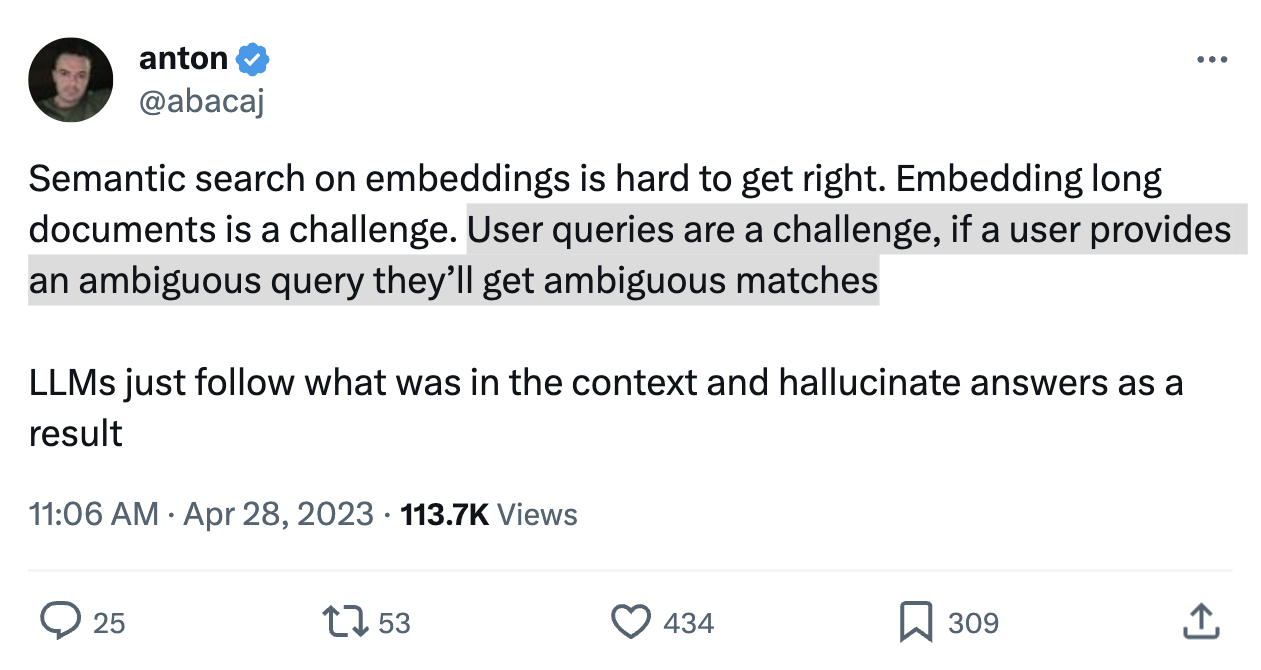
</center>

If our query is poorly structured, our cosine similarity matching will fail to fetch context that is actually relevant to the query.

This brings up the question, how do we convert the ambiguous query to a non-ambiguous one?

# Query Transformations

- **Query transformations** is one of the approaches to solve the "ambiguous query" problem. \
Query transformation deals with transformations of the user's question before passing to the embedding model.

For performing query transformations, we can chose one of the three strategies available. The core difference between each strategy is the level of abstraction.

<center>
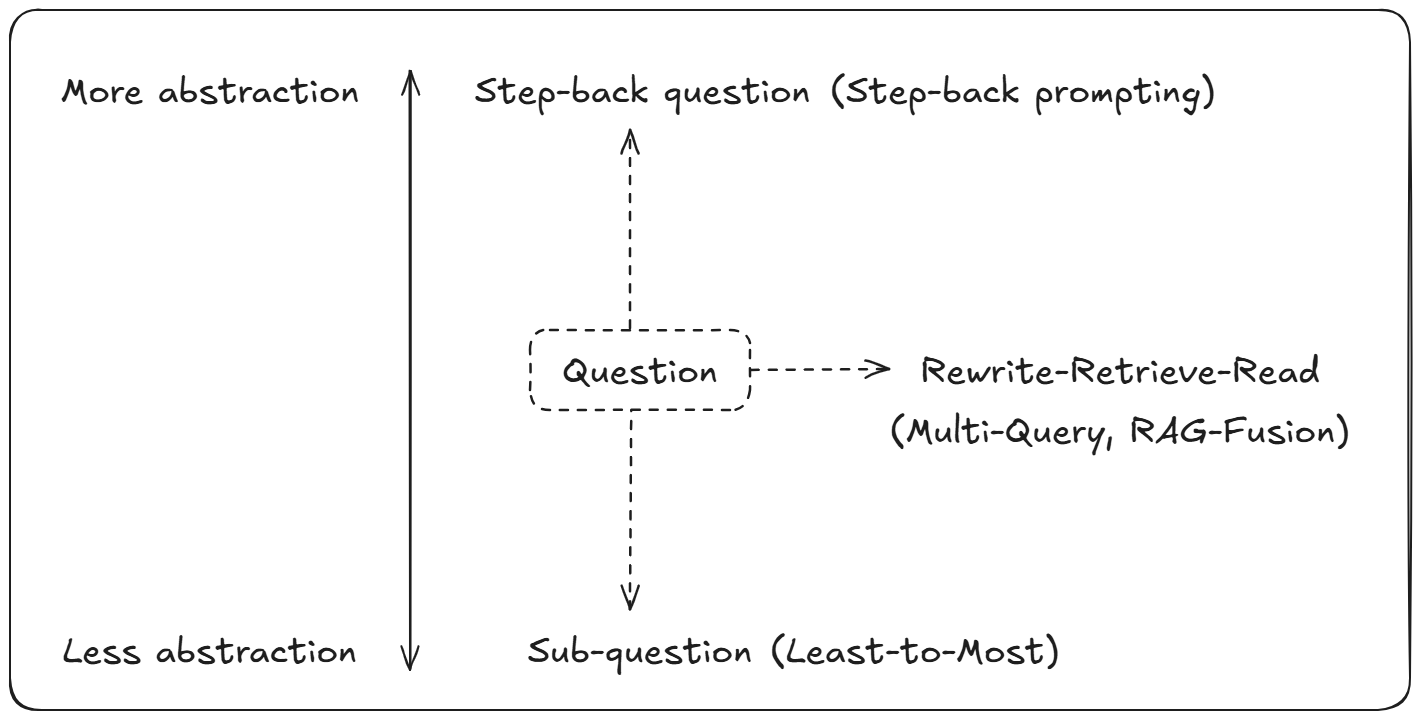
</center>

## 1. Rewrite-Retrieve-Read

- If you think of a naive RAG pipeline, the general flow is that you take the users question and pass that directly to an embedding model. That embedding is then compared to documents stored in the vectorstore, and the top k most similar ones are returned.

<center>
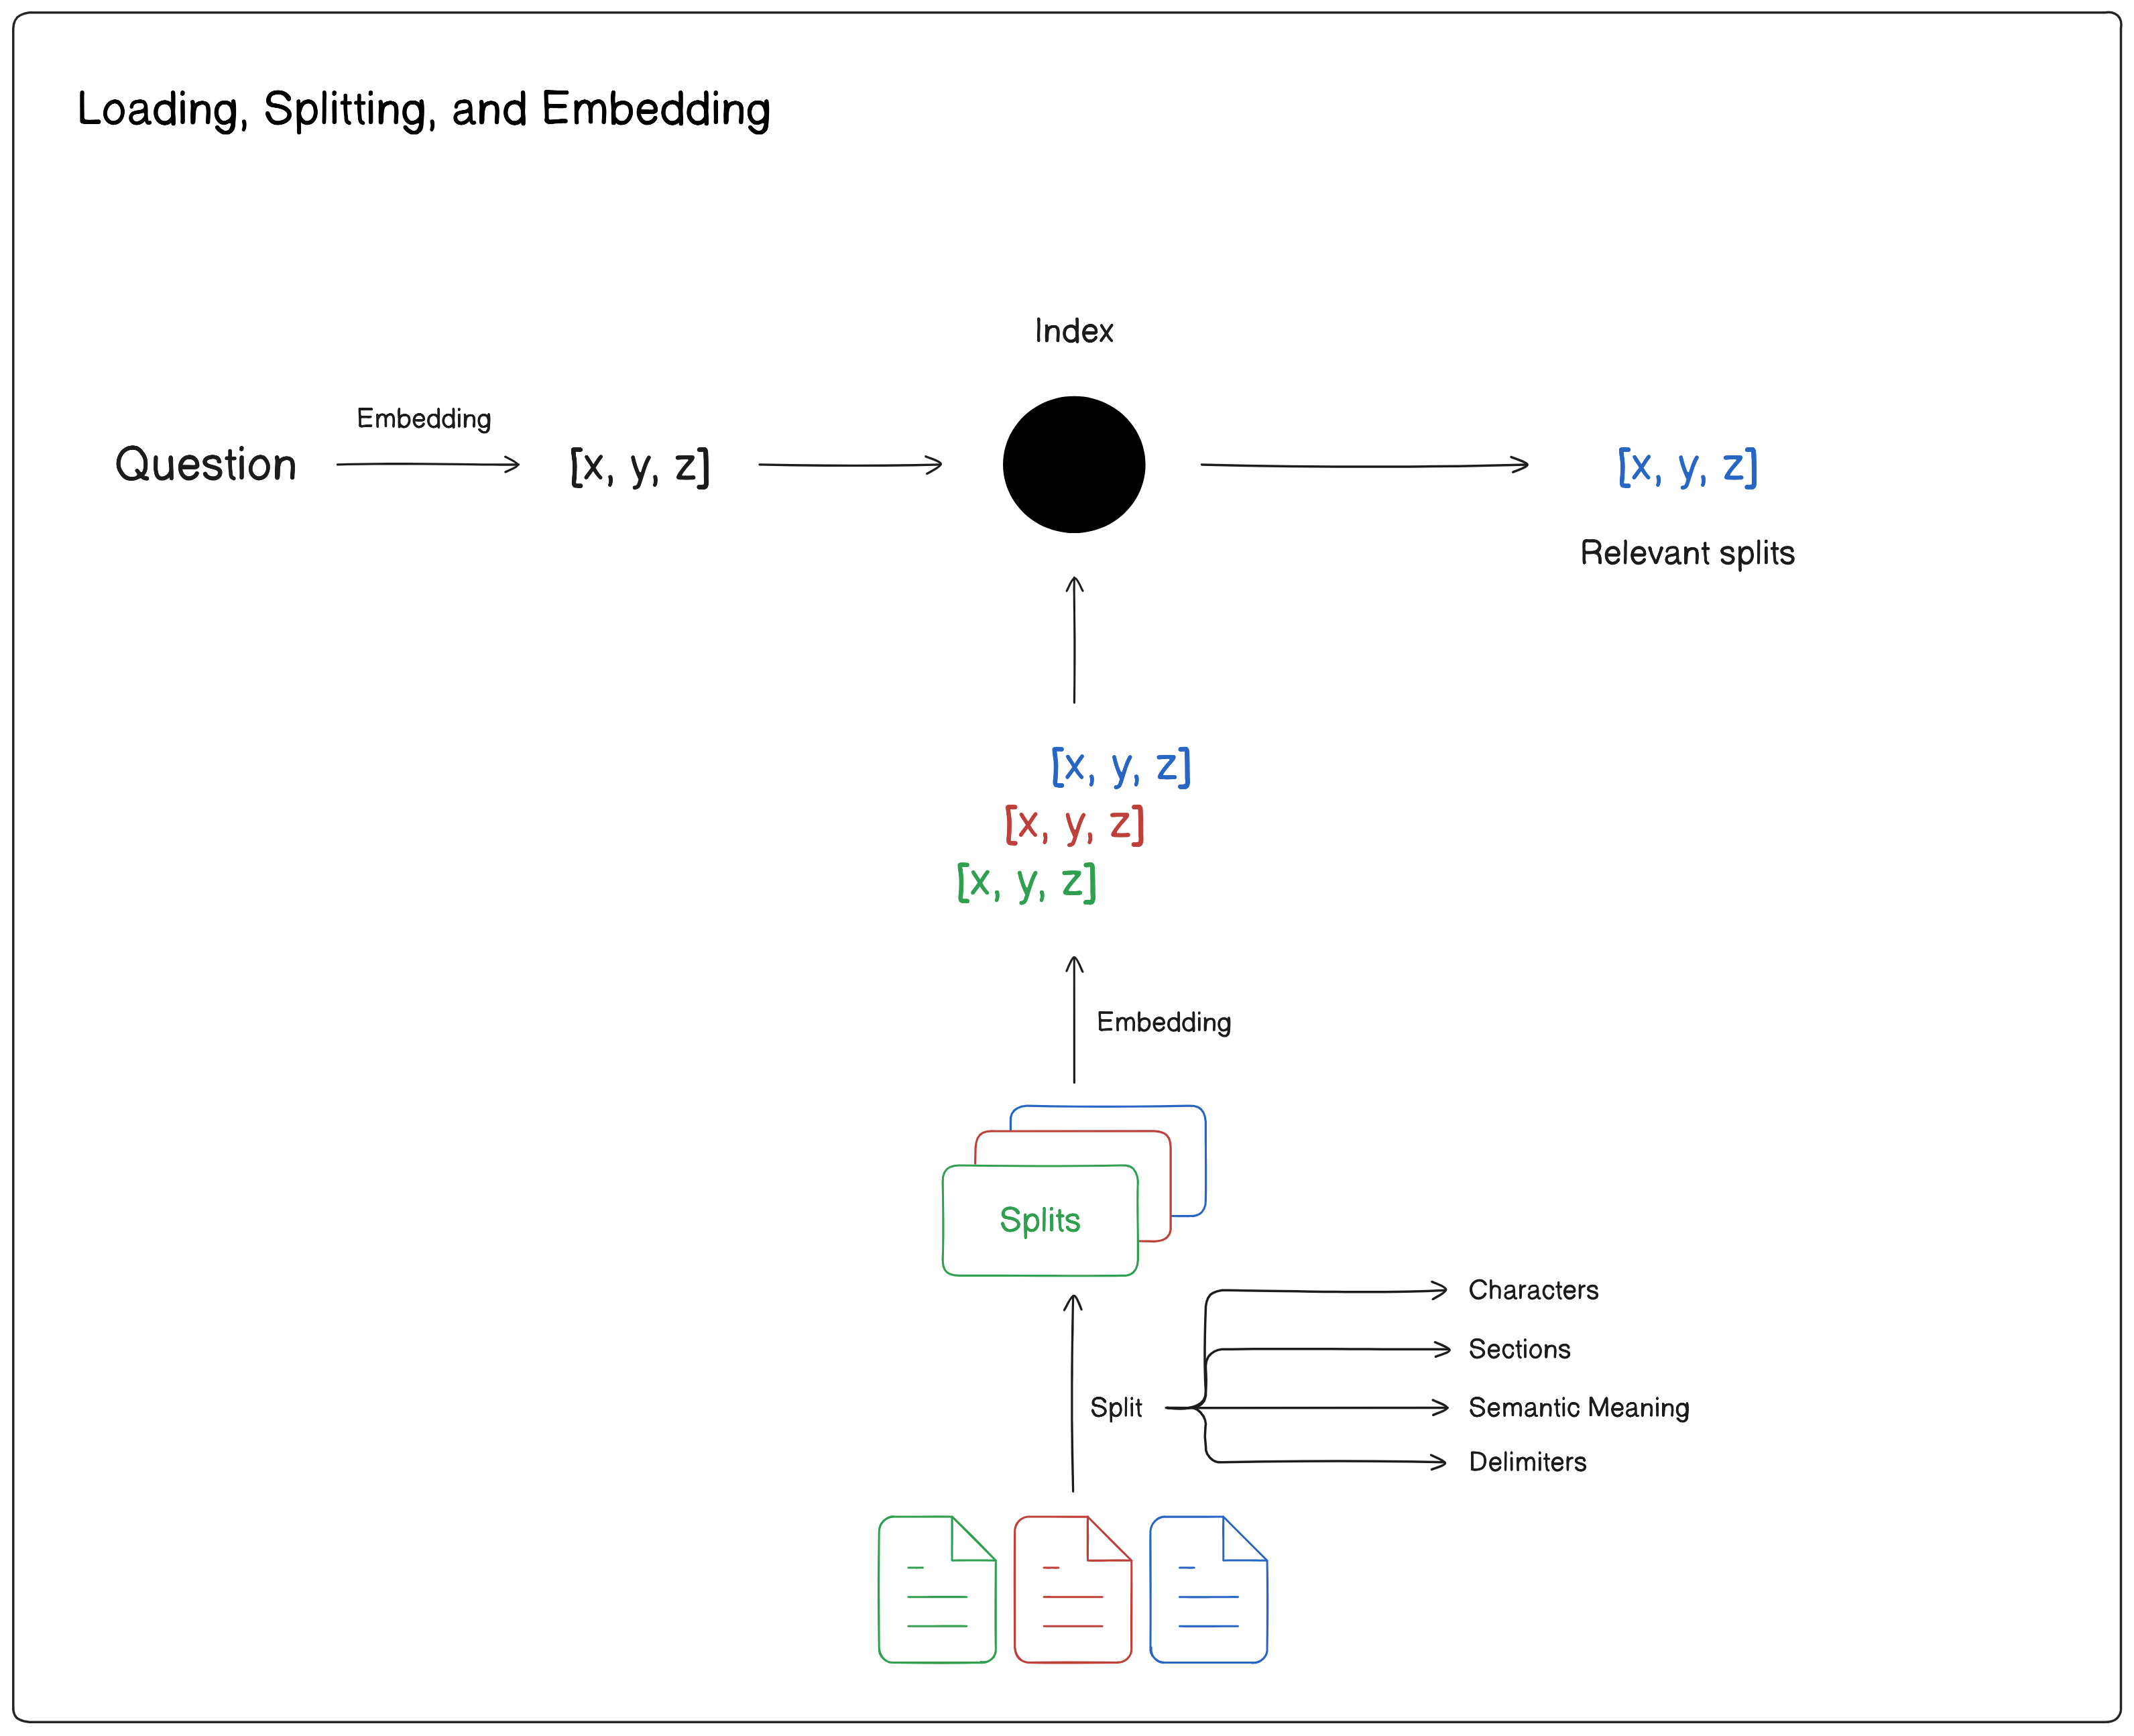
</center>

- Because this naive RAG implementation would be pretty inefficient for ambiguous queries, we introduce the concept of **"Rewrite-Retrieve-Read"**.
- The core idea behind this approach is that we pass the question to the LLM and ask it to rewrite the question in various ways, hereby curating a list of different ways we could ask the same question. 
- Now, Rewrite-Retrieve-Read can be implemented in two ways: 
    - Multi-Query
    - RAG Fusion

### 1.1 Multi-Query

The Multi-Query approach is the simplest implementation of Rewrite-Retrieve-Read.
- We simply pass the question to the LLM, and ask it to rewrite the question in various ways, and save all the variations of the question.
- For each variation of the question, we lookup the relevant chunks in the vector store, and curate a list of relevant chunks.
- We bundle all fetched chunks as a large context, and pass it to the LLM with the question.

<center>

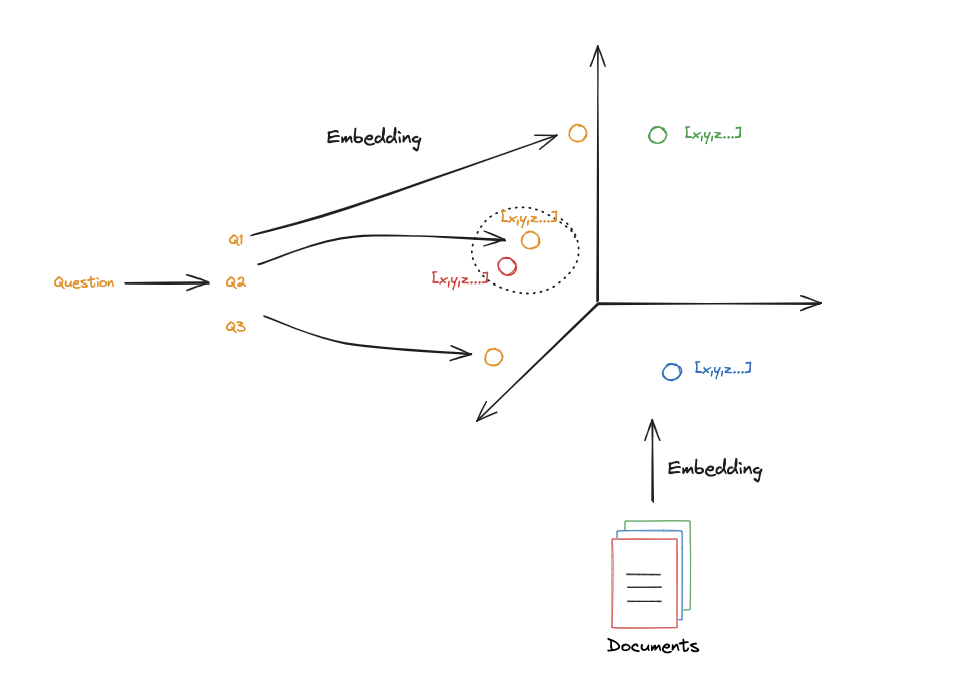

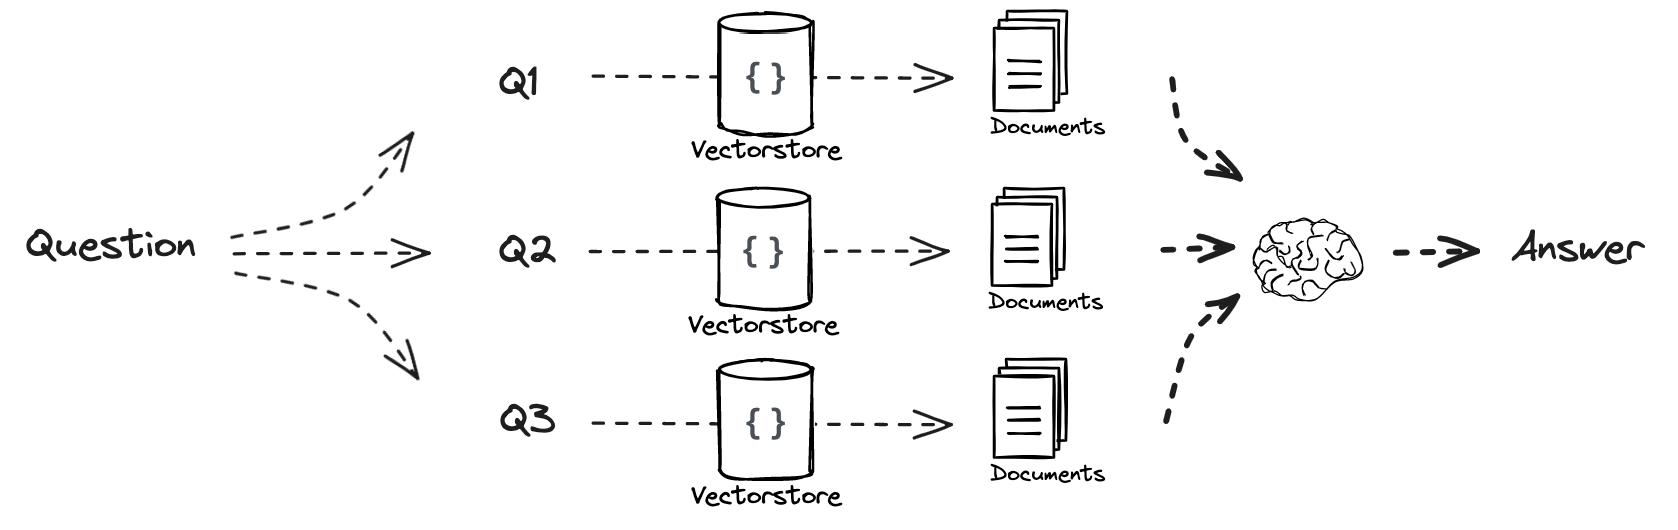

</center>

Let's try implementing a Multi-Query Retriever with LangChain. We'll use the ChromaDB vectorstore created in `Part1` which contains the [LLM Powered Autonomous Agents](https://lilianweng.github.io/posts/2023-06-23-agent/) blog authored by [Lilian Weng](https://www.linkedin.com/in/lilianweng).

In [2]:
# Same code copied from Part1 notebook

import os
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings


vectorstore = Chroma(
    collection_name    = "github_blog_collection",
    persist_directory  = "./rag_with_langchain_database",
    embedding_function = OpenAIEmbeddings(
        model   = "text-embedding-3-large",
        api_key = os.getenv("OPENAI_API_KEY", None)
    )
)

Now, as discussed in the above points, we need to pass the user's query to the LLM and ask the LLM to rewrite it in multiple ways.
To achieve this, we can either create our own prompt via the `ChatPromptTemplate` or pull a prompt from the prompt hub.

Let's take a look at the prompt available on the prompt hub.

In [3]:
from langchain import hub

rewrite_prompt = hub.pull("langchain-ai/rewrite")

rewrite_prompt.template

'Provide a better search query for web search engine to answer the given question, end the queries with ’**’.  Question {x} Answer:'

Well that looks.. disappointing. The good news is, we can write our own prompt! 

In [6]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

import os

# Define the prompt template
rewrite_prompt_template = """
You are an AI language model assistant. 
Your task is to generate five different versions of the given user question to retrieve relevant documents from a vector database. 
By generating multiple perspectives on the user question, your goal is to help the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}
"""

new_prompts = ChatPromptTemplate.from_template(template=rewrite_prompt_template)

llm = ChatOpenAI(
    model       = "gpt-4o",
    api_key     = os.getenv("OPENAI_API_KEY", None),
    temperature = 0
)

# Define the pipeline, with output processing to split by newlines
generate_new_queries = (
    new_prompts
    | llm
    | StrOutputParser()
    | (lambda line: line.split("\n"))
)

# User query
query = "What are the approaches to Task Decomposition?"

# Invoke the pipeline
new_queries = generate_new_queries.invoke({"question": query})

new_queries

['What methods are used for breaking down tasks into smaller components?  ',
 'How can tasks be effectively decomposed into manageable parts?  ',
 'What strategies exist for task decomposition in project management?  ',
 'What are the techniques for dividing tasks into sub-tasks?  ',
 'How do experts approach the process of task decomposition?']

Great! With our query rewrite logic, we rewrote the user's query in 5 different ways.

Now let's run each of these query against our vector database and check if the number of relevant chunks increases or not.

In [ ]:
from langchain.load import loads, dumps

def merge_chunks(docs):
    """ Combine all the unique chunks retrieved from the vector store """

    # Flatten the list of lists, and convert each chunk to string
    chunks_flattened = [dumps(doc) for doc_list in docs for doc in doc_list]

    # Fetch unique chunks
    unique_chunks = list(set(chunks_flattened))

    return [loads(doc) for doc in unique_chunks]


# User query
query = "What are the approaches to Task Decomposition?"

# Define a chunk retrieval pipeline for our rewrite-retrieve-read logic
retriever = vectorstore.as_retriever()
retrieval_chain = generate_new_queries | retriever.map() | merge_chunks

# Check how many chunks were retrieved
relevant_documents = retrieval_chain.invoke({
    "question" : query
})

print("Number of relevant chunks retrieved: ", len(relevant_documents))

Number of relevant chunks retrieved:  6


We found `6` relevant chunks, which is higher than the `3` relevant chunks we found in `Part1`

Now let's connect the Rewrite-Retrieve-Read Multi-Query pipeline with our RAG pipeline and produce a final result.

In [11]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

prompt_template = """
You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use ten sentences maximum and keep the answer concise.

Relevant context for the upcoming question:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template=prompt_template)

# RAG chain with rewrite-retrieve-read
final_rag_chain = (
    {
        "context"   : retrieval_chain, 
        "question"  : itemgetter("question")
    } 
    | prompt
    | llm
    | StrOutputParser()
)

for chunk in final_rag_chain.stream({"question": query}):
    print(chunk, end="", flush=True)

The approaches to Task Decomposition include:

1. **Chain of Thought (CoT)**: This technique involves instructing the model to "think step by step," breaking down complex tasks into smaller, manageable steps. It enhances model performance by utilizing more computation during test time.

2. **Tree of Thoughts**: This method extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure. It involves decomposing the problem into multiple thought steps and generating multiple thoughts per step. The search process can be conducted using breadth-first search (BFS) or depth-first search (DFS), with each state evaluated by a classifier or majority vote.

3. **Task-specific Instructions**: This approach uses specific prompts tailored to the task at hand, such as "Write a story outline" for writing a novel, to guide the decomposition process.

4. **Human Inputs**: Involving human inputs to assist in breaking down tasks into subgoals or steps.

These methods hel

### 1.2 RAG Fusion

- In our Multi-Query approach, we rewrite our question in various ways through an LLM, and for each variation we fetch the relevant context from the vector store.
- Because there are multiple variations of the same question, it is very likely that our RAG may fetch various kinds of relevant chunks from the vector store, which will form a large context for our question. 
- While all the chunks are relevant with regards to the question, are all chunks equally relevant? RAG Fusion solves this by introducing a Reciprocal Rank Fusion.

Reciprocal Rank Fusion (RRF) is a technique for combining the ranks of multiple search result lists to produce a single, unified ranking. In the words of its authors, "yields better results than any individual system, and better results than standard" reranking methods. By combining ranks from different queries, we increase the chances that the most relevant documents will appear at the top of the final list.

$$
\begin{aligned}
RRFscore(d \in D) &= \sum_{r \in R} \frac{1}{k + r(d)} \\
\text{where:} & \\
D &= \text{set of documents to be ranked} \\
R &= \text{set of rankings} \\
k &= 60
\end{aligned}
$$

## References

- [Query Rewriting for Retrieval-Augmented Large Language Models](https://arxiv.org/pdf/2305.14283)
- [Take a Step Back: Evoking Reasoning via Abstraction in Large Language Models](https://arxiv.org/pdf/2310.06117)
- [LangChain - Query Transformations](https://blog.langchain.dev/query-transformations/)
- [LangChain - How to use the MultiQueryRetriever](https://python.langchain.com/docs/how_to/MultiQueryRetriever/)
- [*PAYWALL* Forget RAG, the Future is RAG-Fusion](https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)
- [*UNLOCKED* Forget RAG, the Future is RAG-Fusion](https://freedium.cfd/https://towardsdatascience.com/forget-rag-the-future-is-rag-fusion-1147298d8ad1)
- [Reciprocal Rank Fusion outperforms Condorcet and individual Rank Learning Methods](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf)